In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1
from tqdm import tqdm

In [2]:
# Load base dataset
df = pd.read_csv("data/f1_ml_laps_dataset.csv")

fastf1.Cache.enable_cache("cache")

# New derived features
new_cols = [
    "speed_min", "speed_std", "speed_q1", "speed_q3", "speed_range",
    "throttle_max", "throttle_min", "throttle_std", "throttle_pct_full",
    "brake_std", "brake_pct_braking",
    "rpm_std",
    "gear_changes", "gear_min", "gear_max",
    "drs_active_pct", "drs_time_seconds"
]

In [3]:
# Create empty columns
for col in new_cols:
    df[col] = np.nan

# Group by session for fewer reloads
grouped = df.groupby(["season", "gp_name", "session_name"])

print("\nStarting bonus feature extraction...\n")


Starting bonus feature extraction...



In [4]:
for (season, gp_name, session_name), group in tqdm(grouped, desc="Sessions"):

    try:
        # session_name: "Race" -> only need first letter "R"
        session = fastf1.get_session(int(season), gp_name, session_name[0])
        session.load()
    except Exception as e:
        print(f"❌ Could not load {season} {gp_name} {session_name}: {e}")
        continue

    laps = session.laps

    for idx, row in group.iterrows():
        lap_number = int(row["lap_number"])
        driver = row["driver"]

        lap = laps[(laps["LapNumber"] == lap_number) & (laps["Driver"] == driver)]
        if lap.empty:
            continue

        lap = lap.iloc[0]

        try:
            tel = lap.get_car_data().add_distance()
        except:
            continue

        # ==============================
        # SPEED FEATURES
        # ==============================
        speed = tel["Speed"]
        df.loc[idx, "speed_min"] = speed.min()
        df.loc[idx, "speed_std"] = speed.std()
        df.loc[idx, "speed_q1"] = speed.quantile(0.25)
        df.loc[idx, "speed_q3"] = speed.quantile(0.75)
        df.loc[idx, "speed_range"] = speed.max() - speed.min()

        # ==============================
        # THROTTLE FEATURES
        # ==============================
        thr = tel["Throttle"]
        df.loc[idx, "throttle_max"] = thr.max()
        df.loc[idx, "throttle_min"] = thr.min()
        df.loc[idx, "throttle_std"] = thr.std()
        df.loc[idx, "throttle_pct_full"] = (thr == 100).mean()

        # ==============================
        # BRAKE FEATURES
        # ==============================
        br = tel["Brake"]
        df.loc[idx, "brake_std"] = br.std()
        df.loc[idx, "brake_pct_braking"] = (br > 0).mean()

        # ==============================
        # RPM FEATURES
        # ==============================
        rpm = tel["RPM"]
        df.loc[idx, "rpm_std"] = rpm.std()

        # ==============================
        # GEAR FEATURES
        # ==============================
        gear = tel["nGear"]
        df.loc[idx, "gear_min"] = gear.min()
        df.loc[idx, "gear_max"] = gear.max()
        df.loc[idx, "gear_changes"] = (gear.diff().abs() > 0).sum()

        # ==============================
        # DRS FEATURES
        # ==============================
        if "DRS" in tel.columns:
            drs_mask = tel["DRS"] > 0
            df.loc[idx, "drs_active_pct"] = drs_mask.mean()
            
            try:
                dt = np.mean(np.diff(tel["Time"].dt.total_seconds()))
            except:
                dt = 0
            df.loc[idx, "drs_time_seconds"] = drs_mask.sum() * dt



Sessions:   0%|          | 0/22 [00:00<?, ?it/s]core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']
Sessions:   

In [5]:
# Save output
out_path = "data/final_f1_ml_laps_dataset.csv"
df.to_csv(out_path, index=False)

print("\n🎉 BONUS DATASET SAVED →", out_path)
print("Rows:", len(df), "Columns:", len(df.columns))



🎉 BONUS DATASET SAVED → data/final_f1_ml_laps_dataset.csv
Rows: 23983 Columns: 48


Loaded bonus dataset. Shape: (23983, 48)

🔍 Top Positive Correlations with lap_time:
lap_time             1.000000
sector_1_time        0.751240
sector_2_time        0.658705
sector_3_time        0.523543
gear_changes         0.508216
drs_activations      0.420482
drs_time_seconds     0.420354
rpm_std              0.307628
drs_active_pct       0.300254
speed_range          0.258272
speed_std            0.170687
pressure             0.169228
air_temp             0.158352
track_status         0.131360
rpm_max              0.126518
position             0.076617
brake_mean           0.055376
brake_pct_braking    0.055376
wind_speed           0.047414
brake_std            0.041734
Name: lap_time, dtype: float64

🔍 Top Negative Correlations with lap_time:
gear_max             0.027127
throttle_min        -0.006425
humidity            -0.018279
throttle_max        -0.019243
wind_dir            -0.027973
speed_max           -0.077850
track_temp          -0.092839
throttle_pct_full   -0.121005


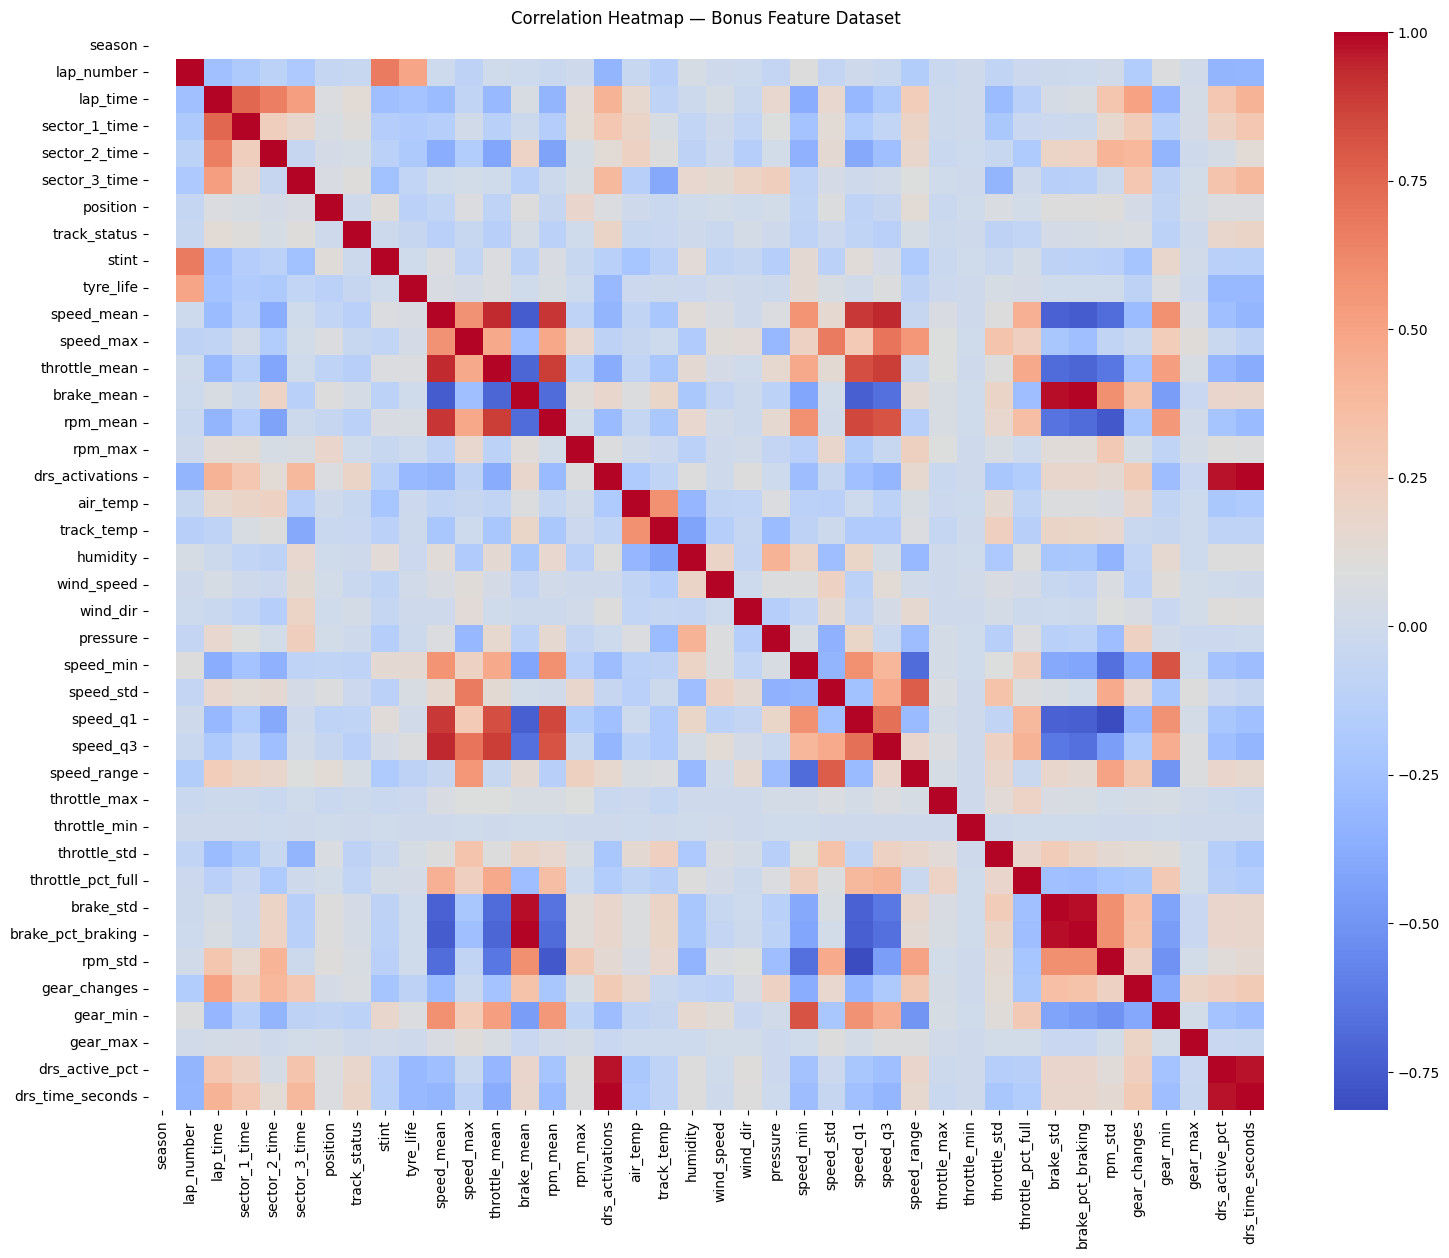

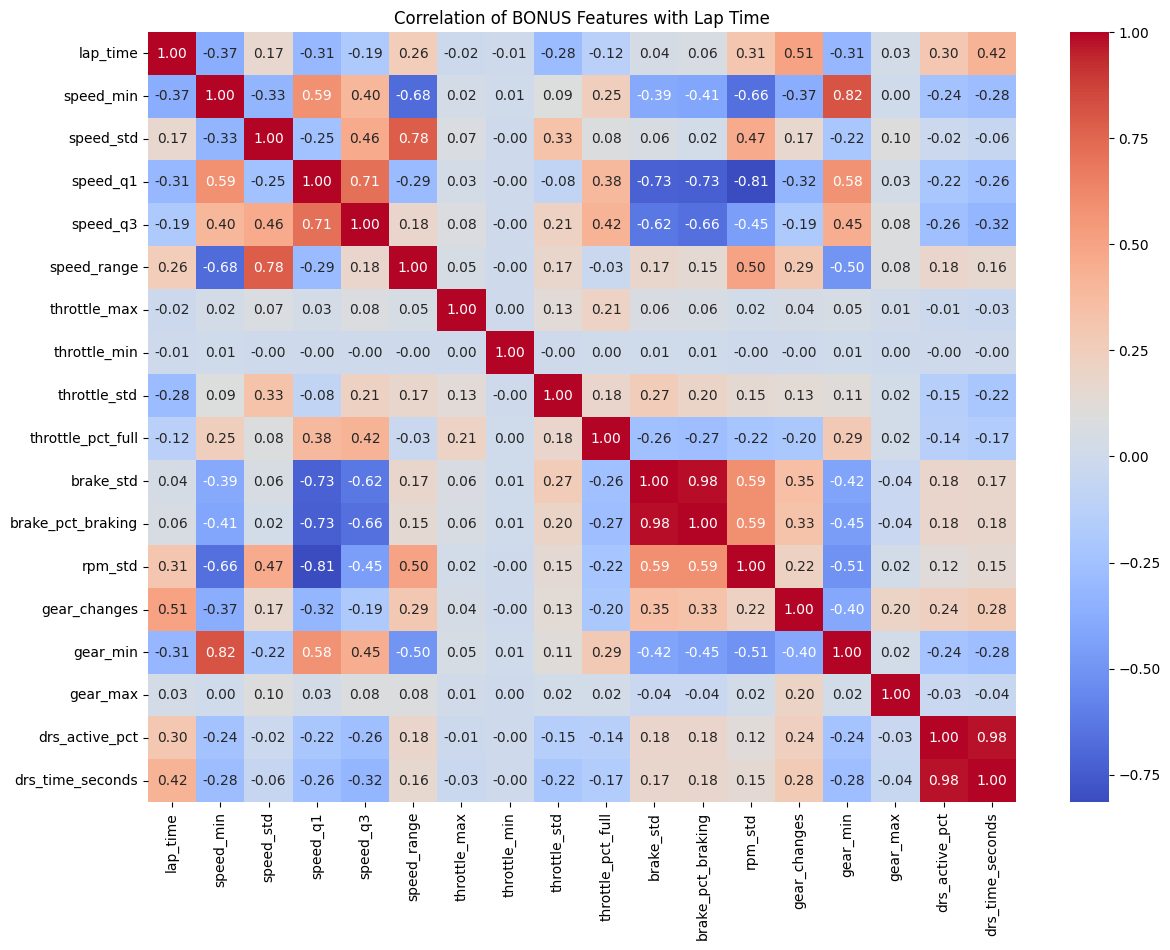

In [6]:
# ================================================
# 📌 CORRELATION ANALYSIS FOR BONUS FEATURE DATASET
# ================================================
df_bonus = pd.read_csv("data/final_f1_ml_laps_dataset.csv")

print("Loaded bonus dataset. Shape:", df_bonus.shape)
df_bonus.head()


# -----------------------------
# Only numeric features for correlation
# -----------------------------
numeric_df = df_bonus.select_dtypes(include=[np.number])

corr = numeric_df.corr()

# Sort correlations with lap_time
corr_lap = corr["lap_time"].sort_values(ascending=False)

print("\n🔍 Top Positive Correlations with lap_time:")
print(corr_lap.head(20))

print("\n🔍 Top Negative Correlations with lap_time:")
print(corr_lap.tail(20))


# -----------------------------
# Heatmap of correlations
# -----------------------------
plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap — Bonus Feature Dataset")
plt.show()


# -----------------------------
# Heatmap for BONUS features only
# -----------------------------
bonus_cols = [
    "speed_min", "speed_std", "speed_q1", "speed_q3", "speed_range",
    "throttle_max", "throttle_min", "throttle_std", "throttle_pct_full",
    "brake_std", "brake_pct_braking",
    "rpm_std",
    "gear_changes", "gear_min", "gear_max",
    "drs_active_pct", "drs_time_seconds"
]

bonus_corr = df_bonus[["lap_time"] + bonus_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(bonus_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation of BONUS Features with Lap Time")
plt.show()
